In [2]:
# Importação das bibliotecas necessárias
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

2025-02-22 20:47:36.282897: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 20:47:36.505418: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 20:47:36.667049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740268056.811584   12648 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740268056.851076   12648 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 20:47:37.214473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# Defina os caminhos para os diretórios do dataset
# Supondo que o dataset esteja organizado em:
# - dataset/train/normal, dataset/train/pneumonia
# - dataset/val/normal, dataset/val/pneumonia
# - dataset/test/normal, dataset/test/pneumonia
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Parâmetros
img_width, img_height = 224, 224  # Tamanho de entrada esperado pelo VGG16
batch_size = 32

In [5]:
# Criação dos ImageDataGenerators para treino, validação e teste
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#####

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,      # Para avaliação, processamos uma imagem por vez
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


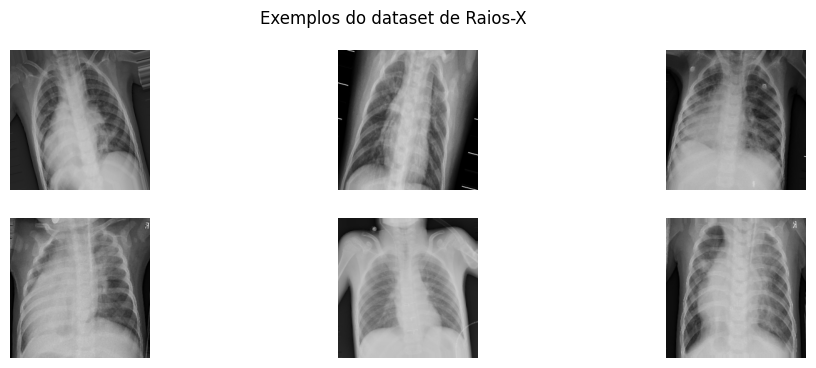

In [6]:
# Exibição de alguns exemplos do dataset
import random
sample_imgs, _ = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
plt.suptitle("Exemplos do dataset de Raios-X")
plt.show()

In [7]:
# Construção da arquitetura utilizando transferência de aprendizado com VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Congela as camadas do VGG16
for layer in base_model.layers:
    layer.trainable = False

2025-02-22 20:48:01.913838: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
# Adiciona camadas customizadas para a classificação binária
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # saída para classificação binária

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Treinamento do modelo
epochs = 10  # ajuste conforme necessário
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)


/home/deg/Documentos/victor/inteligencia-artificial/ia_venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-02-22 20:50:31.666477: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-02-22 20:50:31.893923: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-02-22 20:50:32.541744: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-02-22 20:50:32.672300: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-02-22 20:50:32.833983: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


163/163 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.6090 - loss: 0.6878 - val_accuracy: 0.5000 - val_loss: 0.7721
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.7610 - loss: 0.4743 - val_accuracy: 0.5625 - val_loss: 0.7254
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.8193 - loss: 0.3826 - val_accuracy: 0.5625 - val_loss: 0.7256
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.8529 - loss: 0.3299 - val_accuracy: 0.6250 - val_loss: 0.6543
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.8810 - loss: 0.2927 - val_accuracy: 0.6250 - val_loss: 0.6943
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.9023 - loss: 0.2636 - val_accuracy: 0.6250 - val_loss: 0.6985
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.9044 - loss: 0.2448 - val_accuracy: 0.6875 - val_loss: 0.6803
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.9125 - loss: 0.2328 - val_accuracy: 0.687

In [12]:
# Salvando o modelo no formato HDF5
model.save('modelo_pneumonia.h5')

In [14]:
model.save('modelo_pneumonia.keras')

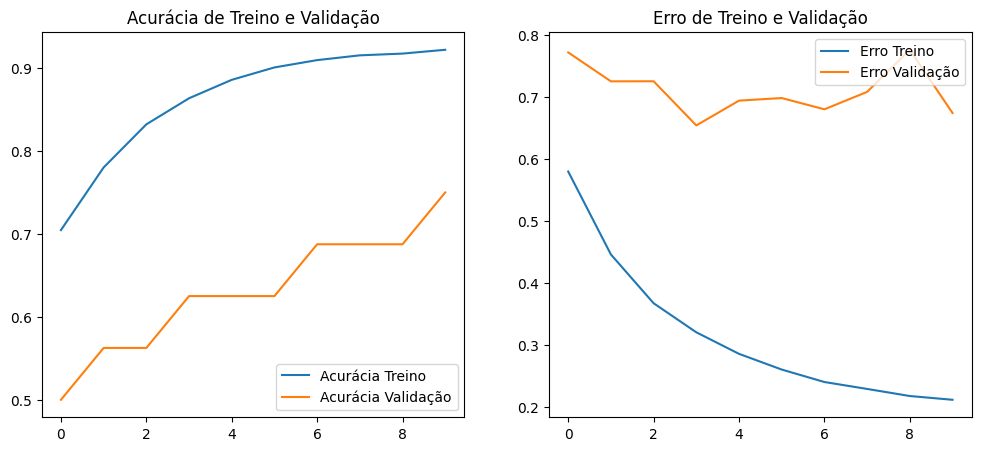

In [11]:
# Plotando as curvas de treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia Treino')
plt.plot(epochs_range, val_acc, label='Acurácia Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro Treino')
plt.plot(epochs_range, val_loss, label='Erro Validação')
plt.legend(loc='upper right')
plt.title('Erro de Treino e Validação')
plt.show()

In [15]:
# Avaliação do modelo no conjunto de teste
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)
# Como usamos ativação sigmoide, limiaramos a probabilidade em 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Extraindo as classes reais
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Imprime o relatório de classificação
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Relatório de Classificação:\n", report)

624/624 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step
Relatório de Classificação:
               precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624

